<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Авторы материала: Павел Нестеров. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашняя работа №4
## <center> Логистическая регрессия в задаче тегирования вопросов StackOverflow

**Надо вывести формулы, где это просится (да, ручка и бумажка), заполнить код в клетках и выбрать ответы в [веб-форме](https://docs.google.com/forms/d/1I_ticU8rpeoGJjsBUcaInpvgdxdq60hV7IcSvo4rlGo/).**

## 0. Описание задачи

В этой домашней работе мы с вами изучим и запрограммируем модель для прогнозирования тегов по тексту вопроса на базе многоклассовой логистической регрессии. В отличие от обычной постановки задачи классификации (multiclass), в данном случае один пример может принадлежать одновременно к нескольким классам (multilabel). Мы будем реализовывать онлайн версию алгоритма мультиклассовой классификации.

Мы будем использовать небольшую выборку из протеггированных вопросов с сайта StackOverflow размером в 125 тысяч примеров (около 150 Мб, скачайте по [этой](https://drive.google.com/open?id=0B4bl7YMqDnViYVo0V2FubFVhMFE) ссылке).

PS: Можно показать, что такая реализация совсем не эффективная и проще было бы использовать векторизированные вычисления. Для данного датасета так и есть. Но на самом деле подобные реализации используются в жизни, но естественно, написаны они не на Python. Например, в онлайн моделях прогнозирования [CTR](https://en.wikipedia.org/wiki/Click-through_rate) юзеру показывается баннер, затем в зависимости от наличия клика происходит обновление параметров модели. В реальной жизни параметров модели может быть несколько сотен миллионов, а у юзера из этих ста миллионов от силы сто или тысяча параметров отличны от нуля, векторизировать такие вычисления не очень эффективно. Обычно все это хранится в огромных кластерах в in-memory базах данных, а обработка пользователей происходит распределенно.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
from tqdm import tqdm_notebook
import pandas as pd
from collections import defaultdict

# поменяйте на свой путь
DS_FILE_NAME = '../../data/stackoverflow_sample_125k.tsv'
TAGS_FILE_NAME = '../../data/top10_tags.tsv'

In [2]:
top_tags = []
with open(TAGS_FILE_NAME, 'r') as f:
    for line in f:
        top_tags.append(line.strip())
top_tags = set(top_tags)
print(top_tags)

{'android', 'java', 'c++', 'python', 'c#', 'php', 'javascript', 'ios', 'html', 'jquery'}


## 1. Многоклассовая логистическая регрессия

Вспомним, как получается логистическая регрессия для двух классов $\left\{0, 1\right\}$, вероятность принадлежности объекта к классу $1$ выписывается по теореме Байеса:

$$\large \begin{array}{rcl}
p\left(c = 1 \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right) + p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} \\
&=& \dfrac{1}{1 + e^{-a}} \\
&=& \sigma\left(a\right)
\end{array}$$
где:
- $\vec{x}$ – вектор признаков объекта
- $\sigma$ – обозначение функции логистического сигмоида при скалярном аргументе
- $a = \log \frac{p\left(\vec{x} \mid c = 1\right)p\left(c = 1\right)}{p\left(\vec{x} \mid c = 0\right)p\left(c = 0\right)} = \sum_{i=0}^M w_i x_i$ – это отношение мы моделируем линейной функцией от признаков объекта и параметров модели

Данное выражение легко обобщить до множества из $K$ классов, изменится только знаменатель в формуле Байеса. Запишем вероятность принадлежности объекта к классу $k$:
$$\large \begin{array}{rcl}
p\left(c = k \mid \vec{x}\right) &=& \dfrac{p\left(\vec{x} \mid c = k\right)p\left(c = k\right)}{\sum_{i=1}^K p\left(\vec{x} \mid c = i\right)p\left(c = i\right)} \\
&=& \dfrac{e^{z_k}}{\sum_{i=1}^{K}e^{z_i}} \\
&=& \sigma_k\left(\vec{z}\right)
\end{array}$$
где:
- $\sigma_k$ – обозначение функции softmax при векторном аргументе
- $z_k = \log p\left(\vec{x} \mid c = k\right)p\left(c = k\right) = \sum_{i=0}^M w_{ki} x_i$ – это выражение моделируется линейной функцией от признаков объекта и параметров модели для класса $k$

Для моделирования полного правдоподобия примера мы используем [категориальное распределение](https://en.wikipedia.org/wiki/Categorical_distribution), а лучше его логарифм (для удобства):

$$\large \begin{array}{rcl}
\mathcal{L} = \log p\left({\vec{x}}\right) &=& \log \prod_{i=1}^K \sigma_i\left(\vec{z}\right)^{y_i} \\
&=& \sum_{i=1}^K y_i \log \sigma_i\left(\vec{z}\right)
\end{array}$$

Получается хорошо знакомая нам функция [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) (если домножить на $-1$). Правдоподобие нужно максимизировать, а, соответственно, перекрестную энтропию нужно минимизировать. Продифференцировав по параметрам модели, мы _легко_ получим правила обновления весов для градиентного спуска, **проделайте этот вывод, если вы его не делали** (если вы вдруг сдались, то на [этом](https://www.youtube.com/watch?v=-WiR16raQf4) видео есть разбор вывода, понимание этого вам понадобится для дальнейшего выполнения задания):

$$\large \begin{array}{rcl}
\frac{\partial \mathcal{L}}{\partial w_{km}} &=& x_m \left(y_k - \sigma_k\left(\vec{z}\right)\right)
\end{array}$$

В стандартной формулировке получается, что вектор $\left(\sigma_1, \sigma_2, \ldots, \sigma_K\right)$ образует дискретное вероятностное распределение, т.е. $\sum_{i=1}^K \sigma_i = 1$. Но в нашей постановке задачи каждый пример может иметь несколько тегов или одновременно принадлежать к нескольким классам. Для этого мы немного изменим модель:
- будем считать, что все теги независимы друг от друга, т.е. каждый исход – это логистическая регрессия на два класса (либо есть тег, либо его нет), тогда вероятность наличия тега у примера запишется следующим образом (каждый тег/класс как и в многоклассовой логрегрессии имеет свой набор параметров):
$$\large p\left(\text{tag}_k \mid \vec{x}\right) = \sigma\left(z_k\right) = \sigma\left(\sum_{i=1}^M w_{ki} x^i \right)$$
- наличие каждого тега мы будем моделировать с помощью <a href="https://en.wikipedia.org/wiki/Bernoulli_distribution">распределения Бернулли</a>

Ваше первое задание –  записать упрощенное выражение логарифма правдоподобия примера с признаками $\vec{x}$. Как правило, многие алгоритмы оптимизации имеют интерфейс для минимизации функции, мы последуем этой же традиции, и домножим полученное выражение на $-1$, а во второй части выведем формулы для минимизации полученного выражения.

<font color="red">Варианты ответа:</font>
1. $\large -\mathcal{L} = -\sum_{i=1}^M y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
2. $\large -\mathcal{L} = -\sum_{i=1}^K y_i \log \sigma\left(z_i\right) + \left(1 - y_i\right) \log \left(1 - \sigma\left(z_i\right)\right)$
3. $\large -\mathcal{L} = -\sum_{i=1}^K z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$
4. $\large -\mathcal{L} = -\sum_{i=1}^M z_i \log \sigma\left(y_i\right) + \left(1 - z_i\right) \log \left(1 - \sigma\left(y_i\right)\right)$

## 2. Вывод формулы обновления весов

В качестве второго задания вам предоставляется возможность вывести формулу градиента для $-\mathcal{L}$.

<font color="red">Варианты ответа:</font>:
1. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(\sigma\left(z_k\right) - y_k\right)$
2. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = -x_m \left(y_k - \sigma\left(z_k\right)\right)$
3. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(\sigma\left(z_k\right)x_m - y_k\right)$
4. $\large -\frac{\partial \mathcal{L}}{\partial w_{km}} = \left(y_k - \sigma\left(z_k\right)x_m\right)$

## 3. Имплементация базовой модели

Вам предлагается каркас класса модели, разберите его внимательно, обращайте внимание на комментарии. Затем заполните пропуски, запустите полученную модель и ответьте на проверочный вопрос.

Как вы могли уже заметить, при обновлении веса $w_{km}$ используется значение признака $x_m$, который равен $0$ если слова с индексом $m$ нет в предложении, и больше нуля, если такое слово есть. Соответственно, при вычислении линейной комбинации $z$ весов модели и признаков примера необходимо учитывать только ненулевые признаки объекта.

Подсказка:
- если реализовывать вычисление сигмоида так же, как в формуле, то при большом отрицательном значении $z$ вычисление $e^{-z}$ превратится в очень большое число, которое вылетит за допустимые пределы
- в то же время $e^{-z}$ от большого положительного $z$ будет нулем
- воспользуйтесь свойствами функции $\sigma$ для того, чтобы пофиксить эту ошибку

In [23]:
class LogRegressor():
    
    """Конструктор
    
    Параметры
    ----------
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    ----------
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0

                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
                    
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    z = self._b[tag]
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # z += ...
                        z += self._w[tag][self._vocab[word]] 
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sigma = ...
#                     if z < -10: sigma = 0
#                     elif z > 10 : sigma = 1 
#                     else: sigma = 1.0/(1.0 + np.exp((-1.0)*z))
                    sigma = 1.0/(1.0 + np.exp((-1.0)*z))
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sample_loss += ...
                    if y:
                        if sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(sigma)
                    else:
                        if 1 - sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(1 - sigma)
#                     if sigma < tolerance:
#                         sample_loss += (-1.0)*(y*np.log(tolerance) + (1-y)*np.log(1-sigma))
#                     elif (1 - sigma) < tolerance:
#                         sample_loss += (-1.0)*(y*np.log(sigma) + (1-y)*np.log(tolerance))
#                     else:
#                         sample_loss += (-1.0)*(y*np.log(sigma) + (1-y)*np.log(1-sigma))
                        
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        # dLdw = ...
                        dLdw = y - sigma
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:                        
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        self._b[tag] -= -learning_rate*dLdw
                    
                n += 1
                        
                self._loss.append(sample_loss)

In [24]:
# создадим эксемпляр модели и пройдемся по датасету
model = LogRegressor()
model.iterate_file()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: overflow encountered in exp


Проверим, действительно ли значение отрицательного логарифмического правдоподобия уменьшалось. Так как мы используем стохастический градентный спуск, не стоит ожидать плавного падения функции ошибки. Мы воспользуемся скользящим средним с окном в 10 000 примеров, чтобы хоть как то сгладить график.

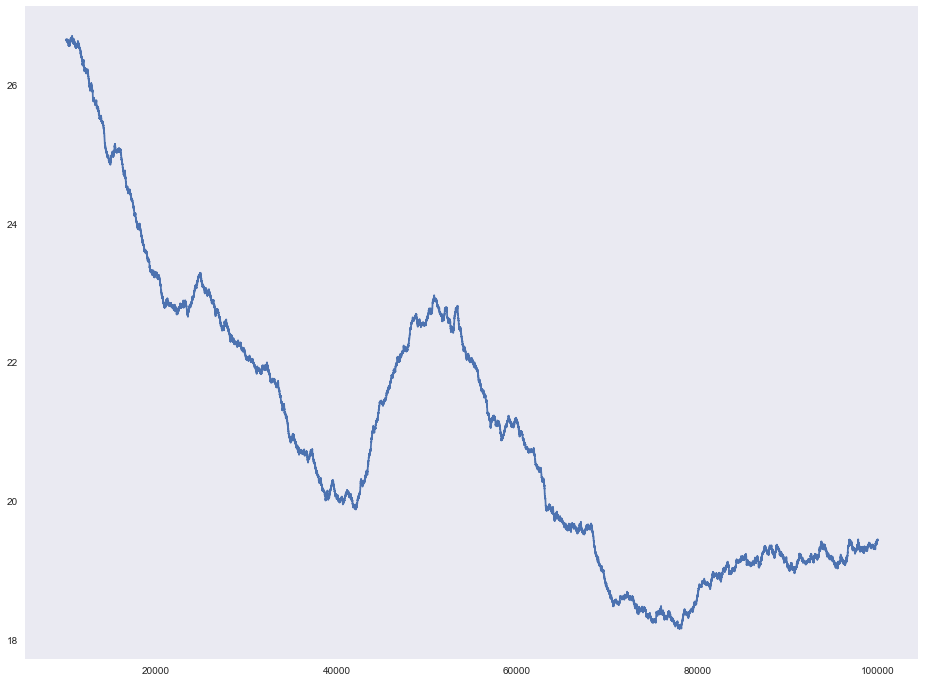

In [25]:
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [26]:
print('Mean of the loss function on the last 10k train samples: %0.2f' % np.mean(model._loss[-35000:-25000]))

Mean of the loss function on the last 10k train samples: 19.44


Вычислите среднее значение функции стоимости на последних 10 000 примеров тренировочного набора, к какому из значений ваш ответ ближе всего?

<font color="red">Варианты ответа:</font>:
1. 17.54
2. 18.64
3. 19.74
4. 20.84

In [18]:
import math
sum = 0
for i in range(8):
    if i>7-i:
        sum += math.factorial(7)/(math.factorial(7-i)*math.factorial(i))*np.power(0.8, i)*np.power(0.2, 7-i)
sum

0.9666560000000004

## 4. Тестирование модели

В базовой модели первые 100 000 строк используются для обучения, а оставшиеся – для тестирования. Как вы можете заметить, значение отрицательного логарифмического правдоподобия не очень информативно, хоть и позволяет сравнивать разные модели. В качестве четвертого задания вам необходимо модифицировать базовую модель таким образом, чтобы метод `iterate_file` возвращал значение _точности_ на тестовой части набора данных. 

Точность определим следующим образом:
- считаем, что тег у вопроса присутствует, если спрогнозированная вероятность тега больше 0.9
- точность одного примера расчитывается как [коэффициент Жаккара](https://ru.wikipedia.org/wiki/Коэффициент_Жаккара) между множеством настоящих тегов и предсказанных моделью
  - например, если у примера настоящие теги ['html', 'jquery'], а по версии модели ['ios', 'html', 'java'], то коэффициент Жаккара будет равен |['html', 'jquery'] $\cap$ ['ios', 'html', 'java']| / |['html', 'jquery'] $\cup$ ['ios', 'html', 'java']| = |['html']| / |['jquery', 'ios', 'html', 'java']| = 1/4
- метод `iterate_file` возвращает **среднюю** точность на тестовом наборе данных

In [ ]:
# Обновите определение класса LogRegressor
# Ваш код здесь

In [ ]:
model = LogRegressor()
acc = model.iterate_file()
# выведем полученное значение с точностью до двух знаков
print('%0.2f' % acc)

Ответьте на вопрос,  к какому значению ближе всего полученное значение точности?
<font color="red">Варианты ответа:</font>:
1. 0.39
2. 0.49
3. 0.59
4. 0.69

## 5. $L_2$-регуляризация

В качестве пятого задания вам необходимо добавить в класс `LogRegressor` поддержку $L_2$-регуляризации. В методе `iterate_file` должен появиться параметр `lmbda=0.01` со значением по умолчанию. С учетом регуляризации новая функция стоимости примет вид:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \frac{\lambda}{2} \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2
\end{array}$$

Градиент первого члена суммы мы уже вывели, а для второго он имеет вид:

$$\large \begin{array}{rcl}
\frac{\partial}{\partial w_{ki}} \frac{\lambda}{2} R\left(W\right) &=& \lambda w_{ki}
\end{array}$$

Если мы на каждом примере будем делать честное обновление всех весов, то все очень замедлится, ведь нам придется на каждой итерации пробегать по всем словам словаря. В ущерб теоретической точности вы используем грязный трюк: мы будем регуляризаровать только те слова, которые присутствуют в текущем предложении. Не забывайте, что смещение не регуляризируется. `sample_loss` тоже должен остаться без изменений.

In [ ]:
# Обновите определение класса LogRegressor
# Ваш код здесь

In [ ]:
model = LogRegressor()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

Ответьте на вопрос, к какому значению ближе всего полученное значение точности?
<font color="red">Варианты ответа:</font>:
1. 0.3
2. 0.35
3. 0.4
4. 0.52

## 6. ElasticNet регуляризация, вывод
Помимо $L_2$ регуляризации, часто используется $L_1$ регуляризация.

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \frac{\lambda}{2} R\left(W\right) \\
&=& -\mathcal{L} + \lambda \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right|
\end{array}$$

Если линейно объединить $L_1$ и $L_2$ регуляризацию, то полученный тип регуляризации называется ElasticNet:

$$\large \begin{array}{rcl}
L &=& -\mathcal{L} + \lambda R\left(W\right) \\
&=& -\mathcal{L} + \lambda \left(\gamma \sum_{k=1}^K\sum_{i=1}^M w_{ki}^2 + \left(1 - \gamma\right) \sum_{k=1}^K\sum_{i=1}^M \left|w_{ki}\right| \right)
\end{array}$$
- где $\gamma \in \left[0, 1\right]$

В качестве шестого вопроса вам предлагается вывести формулу градиента ElasticNet регуляризации (не учитывая $-\mathcal{L}$). 

<font color="red">Варианты ответа:</font>:
1. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) w_{ki}\right)$ 
2. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma \left|w_{ki}\right| + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
3. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(2 \gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$
4. $\large \frac{\partial}{\partial w_{ki}} \lambda R\left(W\right) = \lambda \left(\gamma w_{ki} + \left(1 - \gamma\right) \text{sign}\left(w_{ki}\right)\right)$

## 7. ElasticNet регуляризация, имплементация

В качестве седьмой задачи, вам предлается изменить класс `LogRegressor` таким образом, чтобы метод `iterate_file` принимал два параметра со значениями по умолчанию `lmbda=0.0002` и `gamma=0.1`. Сделайте один проход по датасету с включенной ElasticNet регуляризацией и заданными значениями по умолчанию и ответьте на вопрос.

In [72]:
class LogRegressor3():
    
    """Конструктор
    
    Параметры
    —------—
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    —------—
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     lmbda = 0.0002, #L2-regularization
                     gamma = 0.1, #L1-regularization
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        acc = 0
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0
                pred_tags = set()
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
#                     print(tag, y, sentence)
#                     time.sleep(5)
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab:
                            self._vocab[word] = len(self._vocab)
                        # z += ...
                        z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sigma = ...
#                     if z < -10:
#                         sigma = 0
#                     elif z > 10:
#                         sigma = 1
#                     else:
#                         sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sample_loss += ...
                    if y:
                        if sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(sigma)
                    else:
                        if 1 - sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(1 - sigma)
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        # dLdw = ...
                        dLdw = y - sigma
                        self._b[tag] -= -learning_rate*dLdw
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence:
                            w_ij = self._w[tag][self._vocab[word]]
                            dLdw = y - sigma - lmbda*(2*gamma*w_ij + (1-gamma)*np.sign(w_ij))
                            self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        
                    if n >= top_n_train:
                        if sigma > 0.9:
                            pred_tags.add(tag)
                    
                n += 1
                if (n >= top_n_train):
                    # вычисляем коэфф жаккара
                    jac = len(pred_tags & tags)/len(pred_tags | tags)
                    acc += jac
                
                
                if n%1000 == 0:
                    print(sample_loss)
                    if (n >= top_n_train):
                        print(pred_tags, tags, jac, acc)
                self._loss.append(sample_loss)
            
        return acc/(total-top_n_train)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in exp


37.0286969875
61.0839559634
36.8413614879
22.6181972956
3.60169131935e-05
0.0
5.28614062134
0.000445893267928
0.133945629699
0.0
25.3938766395
0.0
20.4908829423
85.1443254127
36.8413614882
36.9800088619
0.0
36.8413643151
11.3221515448
9.36905105279
33.4535208847
15.3715522286
73.6827229758
27.4279451226
8.77168782439e-10
2.32367636514e-09
1.66533453694e-15
0.0
0.0
39.3804746294
17.7515894997
9.59270713402
0.516929517948
0.0
0.0
19.1650529357
36.8413614899
31.4451095186
62.368064759
0.0
5.62369705746
0.0
51.5616785877
36.8417232055
36.8413614879
0.000869187093229
3.77282649573e-11
1.4812031711e-08
0.0
18.9750544283
0.0
26.0440005487
73.6827229758
18.5226710101
8.90066345051
1.67587011563e-05
0.0
138.721539037
17.6546689578
4.54303261677e-13
73.6827229758
7.95839086689e-09
36.841361575
0.0
4.36776804073
1.96780250781
36.8413614879
3.90500173097
73.9597198644
32.0281231643
36.8413614879
0.000602396304652
38.6511267415
73.6827229758
3.10824138927e-06
36.8413614879
54.6718801914
8.84124105e

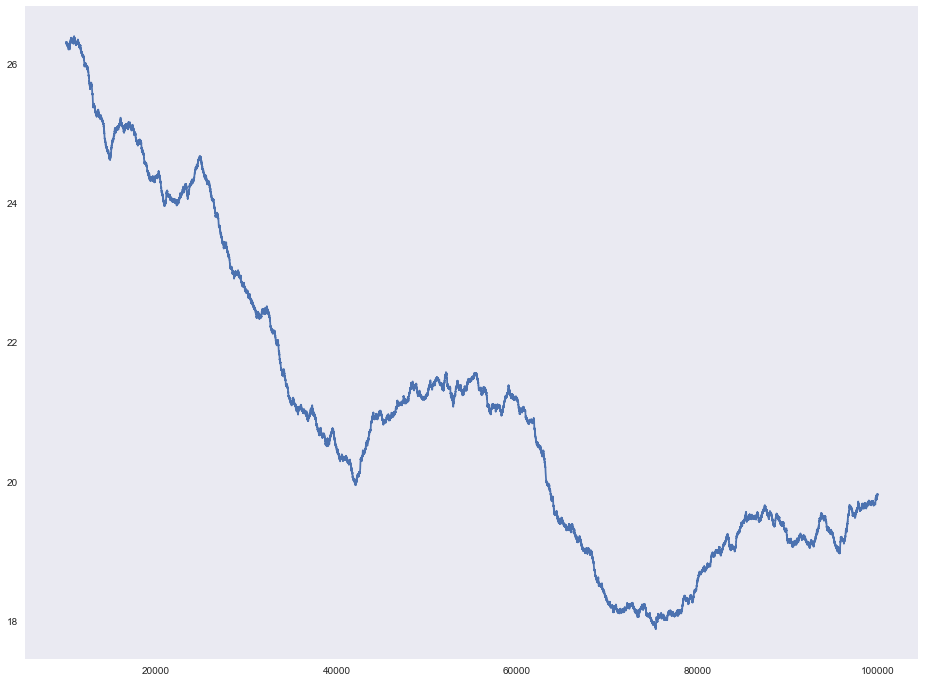

In [73]:
model = LogRegressor3()
acc = model.iterate_file()
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

Ответьте на вопрос,  к какому значению ближе всего полученное значение точности:
<font color="red">Варианты ответа:</font>
1. 0.59
2. 0.69
3. 0.79
4. 0.82

## 8. Самые важные слова для тега

Прелесть линейных моделей в том, что они легко интерпретируемы. Вам предлагается вычислить, какие слова вносят наибольший вклад в вероятность каждого из тегов. А затем ответьте на контрольный вопрос.

In [102]:
# Ваш код здесь
# for tag1 in model._tags:
#     try:
#         print(tag1, model._w[tag1][model._vocab[tag1]])
#     except KeyError:
#         print(tag1, 'wrong key')

count_top_words = 5
top_words = []
for tag in model._tags:
    words = sorted(model._w[tag].items(), key = lambda k: abs(k[1]), reverse=True)[:count_top_words]
    print(words)
    for word in words:
        find_word = ''
        for pair in model._vocab.items():
            if pair[1] == word[0]:
                find_word = pair[0]
        print(tag, ':', model._w[tag][word[0]], find_word)

[(112861, 57.037621694580125), (2587, 49.260763649520506), (2298, 32.05949153009157), (1218, 31.881311973779098), (222, -25.657495676996184)]
c++ : 57.0376216946 avrf
c++ : 49.2607636495 c++
c++ : 32.0594915301 cout
c++ : 31.8813119738 std
c++ : -25.657495677 05
[(742, 76.926195493104188), (3460, 46.667577893967739), (123228, 44.552326597122224), (748, 39.884769326039574), (12907, 39.785408034635445)]
php : 76.9261954931 php
php : 46.667577894 _post
php : 44.5523265971 x5c
php : 39.884769326 echo
php : 39.7854080346 125
[(90844, -52.53555545016782), (2798, 37.450537617348758), (14447, 28.504283760786702), (43485, -24.970226445814923), (105299, -24.879765631505123)]
ios : -52.5355554502 0x0000000000000000
ios : 37.4505376173 ios
ios : 28.5042837608 dylib
ios : -24.9702264458 mingw32
ios : -24.8797656315 w64
[(1639, 100.02621543068364), (1550, -34.987360888186828), (1917, 33.377356671130308), (1570, 33.363879307525949), (66, 32.494355181621842)]
jquery : 100.026215431 jquery
jquery : -34

Для многих тегов наличие самого тега в предложении является важным сигналом, у многих сам тег является самым сильным сигналом, что неудивительно. Для каких из тегов само название тега не входит в топ-5 самых важных?

<font color="red">Варианты ответа:</font>
1. java, c#
2. php, javascript
3. html, jquery
4. ios, android

## 9. Сокращаем размер словаря
Сейчас количество слов в словаре - 519290, если бы это была выборка из 10 миллионов вопросов с сайта StackOverflow, то размер словаря был бы миллионов 10. Регуляризировать модель можно не только изящно математически, но и топорно, например, ограничить размер словаря. Вам предоставляется возможность внести следующие изменения в класс `LogRegressor`:
- добавить в метод `iterate_file` еще один аргумент со значением по умолчанию `update_vocab=True`
- при `update_vocab=True` разрешать добавлять слова в словарь в режиме обучения
- при `update_vocab=False` игнорировать слова не из словаря
- добавить в класс метод `filter_vocab(n=10000)`, который оставит в словаре только топ-n самых популярных слов

In [ ]:
# Обновите определение класса LogRegressor
# Ваш код здесь

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp


37.0286969875
61.0839559634
36.8413614879
22.6181972956
3.60169131935e-05
0.0
5.28614062134
0.000445893267928
0.133945629699
0.0
25.3938766395
0.0
20.4908829423
85.1443254127
36.8413614882
36.9800088619
0.0
36.8413643151
11.3221515448
9.36905105279
33.4535208847
15.3715522286
73.6827229758
27.4279451226
8.77168782439e-10
2.32367636514e-09
1.66533453694e-15
0.0
0.0
39.3804746294
17.7515894997
9.59270713402
0.516929517948
0.0
0.0
19.1650529357
36.8413614899
31.4451095186
62.368064759
0.0
5.62369705746
0.0
51.5616785877
36.8417232055
36.8413614879
0.000869187093229
3.77282649573e-11
1.4812031711e-08
0.0
18.9750544283
0.0
26.0440005487
73.6827229758
18.5226710101
8.90066345051
1.67587011563e-05
0.0
138.721539037
17.6546689578
4.54303261677e-13
73.6827229758
7.95839086689e-09
36.841361575
0.0
4.36776804073
1.96780250781
36.8413614879
3.90500173097
73.9597198644
32.0281231643
36.8413614879
0.000602396304652
38.6511267415
73.6827229758
3.10824138927e-06
36.8413614879
54.6718801914
8.84124105e

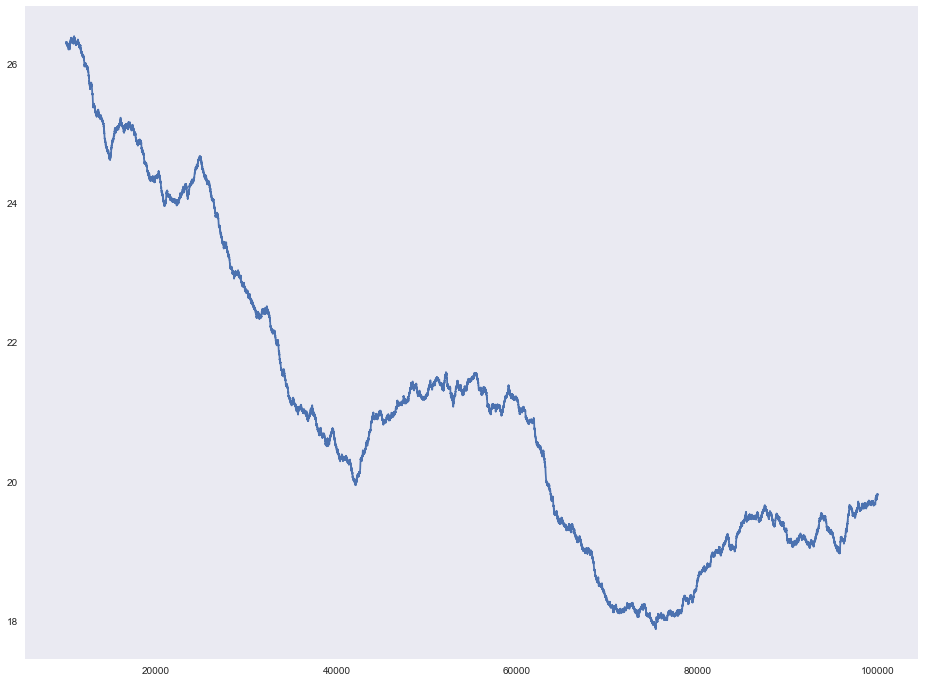

In [61]:
model = LogRegressor4()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

In [63]:
# оставим только топ 10 000 слов
model.filter_vocab_freq(n=10000)

The total word count is: 25269133
Vocab length is: 519290


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp


36.8413616806
36.8413614879
73.6827229758
3.4293470322e-09
6.44851306547e-07
0.766168039033
1.0094793146
73.6827229758
28.8481436155
0.0
12.6929425229
0.000212168504523
44.2218615306
37.2037097912
29.2418372578
73.6827229758
64.9387512334
36.841673982
73.6827229758
0.0663870220429
36.8413614879
4.39611992613
37.1234739955
2.02731135326
36.8413751577
17.6689350626
26.3061030154
0.0
73.6827229758
16.9756491112
5.32685007215e-13
10.2539664602
6.16173778667e-14
0.0
0.00554927999351
36.8413614879
56.7002687181
27.9071696554
44.983239859
3.41321304612e-10
30.6427501937
0.0
36.8428141284
10.9627248747
36.8413614879
4.16634961379
2.89263789792
2.95389879478e-09
3.49802991274e-06
27.8558984073
0.0
0.0027209139008
5.38302140453
1.82126770151
30.4311050302
0.000759596716515
1.24148239112e-08
5.21412664252
20.6941829956
21.3071894992
36.8413614879
36.8421239813
20.6381464926
0.0
61.8169985529
0.0921632209265
2.86437540353e-14
4.52868219979
36.8413621734
23.2951876439
36.8554595787
7.18398243068e-0

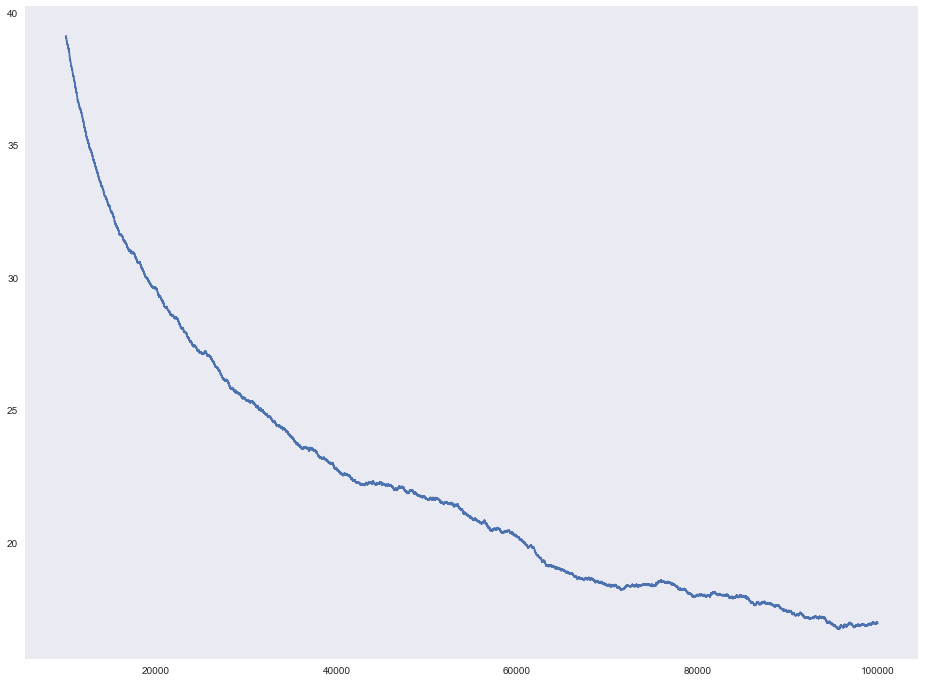

In [64]:
# сделаем еще одну итерацию по датасету, уменьшив скорость обучения в 10 раз
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)
plt.plot(pd.Series(model._loss[:-25000]).rolling(10000).mean());

Ответьте на вопрос,  к какому значению ближе всего полученное значение точности:
<font color="red">Варианты ответа:</font>
1. 0.48
2. 0.58
3. 0.68
4. 0.78

In [68]:
import string
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty level")
for c in string.punctuation:
    if c not in ["'","+","-"]: 
        sentence1 = sentence.replace(c," ")
# print(sentence.lower(), model._w['android'][model._vocab['java']])
print(model.predict_proba(sentence1.lower()))
print(model.predict_proba(sentence.lower()))
# for tag in model._tags:
#     try:
#         print(tag, model._w[tag][model._vocab[tag]])
#     except KeyError:
#         print("c#")

{'c++': 2.0245828282487763e-12, 'php': 0.038827049432199154, 'ios': 0.9076935949609628, 'jquery': 5.6659706218763421e-19, 'android': 0.99527321185941697, 'java': 5.7196391187623855e-15, 'python': 0.0055808811473826566, 'c#': 7.2662392623996445e-10, 'javascript': 1.7471290580232318e-13, 'html': 8.4847480972100965e-10}
{'c++': 2.0245828282487763e-12, 'php': 0.038827049432199154, 'ios': 0.9076935949609628, 'jquery': 5.6659706218763421e-19, 'android': 0.99527321185941697, 'java': 5.7196391187623855e-15, 'python': 0.0055808811473826566, 'c#': 7.2662392623996445e-10, 'javascript': 1.7471290580232318e-13, 'html': 8.4847480972100965e-10}









## 10. Прогнозирование тегов для новых вопросов

В завершение сегодняшней домашки, вам предлагается реализовать метод `predict_proba`, который принимает строку,  содержащую вопрос, а возвращает список предсказанных тегов вопроса с их вероятностями.

In [60]:
from collections import Counter 

class LogRegressor4():
    
    """Конструктор
    
    Параметры
    —------—
    tags_top : list of string, default=top_tags
        список тегов
    """
    def __init__(self, tags=top_tags):      
        # словарь который содержит мапинг слов предложений и тегов в индексы (для экономии памяти)
        # пример: self._vocab['exception'] = 17 означает что у слова exception индекс равен 17
        self._vocab = {}
        
        # параметры модели: веса
        # для каждого класса/тега нам необходимо хранить собственный вектор весов
        # по умолчанию у нас все веса будут равны нулю
        # мы заранее не знаем сколько весов нам понадобится
        # поэтому для каждого класса мы сосздаем словарь изменяемого размера со значением по умолчанию 0
        # пример: self._w['java'][self._vocab['exception']]  содержит вес для слова exception тега java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # параметры модели: смещения или вес w_0
        self._b = dict([(t, 0) for t in tags])
        
        self._tags = set(tags)
    
    """Один прогон по датасету
    
    Параметры
    —------—
    fname : string, default=DS_FILE_NAME
        имя файла с данными
        
    top_n_train : int
        первые top_n_train строк будут использоваться для обучения, остальные для тестирования
        
    total : int, default=10000000
        информация о количестве строк в файле для вывода прогресс бара
    
    learning_rate : float, default=0.1
        скорость обучения для градиентного спуска
        
    tolerance : float, default=1e-16
        используем для ограничения значений аргумента логарифмов
    """
    def iterate_file(self, 
                     fname=DS_FILE_NAME, 
                     top_n_train=100000, 
                     total=125000,
                     learning_rate=0.1,
                     lmbda=0.0002, #L2-regularization
                     gamma=0.1, #L1-regularization
                     update_vocab=True,
                     tolerance=1e-16):
        
        self._loss = []
        n = 0
        acc = 0
        # откроем файл
        with open(fname, 'r') as f:            
            
            # прогуляемся по строкам файла
            for line in tqdm_notebook(f, total=total, mininterval=0.1):
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                # теги вопроса, это y
                tags = set(tags.split(' '))
                
                # значение функции потерь для текущего примера
                sample_loss = 0
                pred_tags = set()
                # прокидываем градиенты для каждого тега
                for tag in self._tags:
                    # целевая переменная равна 1 если текущий тег есть у текущего примера
                    y = int(tag in tags)
#                     print(tag, y, sentence)
#                     time.sleep(5)
                    # расчитываем значение линейной комбинации весов и признаков объекта
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # z = ...
                    
                    z = self._b[tag]
   
                    for word in sentence:
                        # если в режиме тестирования появляется слово которого нет в словаре, то мы его игнорируем
                        if n >= top_n_train and word not in self._vocab:
                            continue
                        if word not in self._vocab and update_vocab:
                            self._vocab[word] = len(self._vocab)
                        # z += ...
                        if word in self._vocab:
                            z += self._w[tag][self._vocab[word]]
    
                    # вычисляем вероятность наличия тега
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sigma = ...
#                     if z < -10:
#                         sigma = 0
#                     elif z > 10:
#                         sigma = 1
#                     else:
#                         sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    sigma = 1.0/(1.0 + np.exp(-1.0*z))
                    # обновляем значение функции потерь для текущего примера
                    # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                    # sample_loss += ...
                    if y:
                        if sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(sigma)
                    else:
                        if 1 - sigma < tolerance:
                            sample_loss += (-1.0)*np.log(tolerance)
                        else:
                            sample_loss += (-1.0)*np.log(1 - sigma)
                    
                    # если мы все еще в тренировочной части, то обновим параметры
                    if n < top_n_train:
                        # вычисляем производную логарифмического правдоподобия по весу
                        # ЗАПОЛНИТЕ ПРОПУСКИ В КОДЕ
                        # dLdw = ...
                        dLdw = y - sigma
                        self._b[tag] -= -learning_rate*dLdw
                        # делаем градиентный шаг
                        # мы минимизируем отрицательное логарифмическое правдоподобие (второй знак минус)
                        # поэтому мы идем в обратную сторону градиента для минимизации (первый знак минус)
                        for word in sentence: 
                            if word in self._vocab:
                                w_ij = self._w[tag][self._vocab[word]]
                                dLdw = y - sigma - lmbda*(2*gamma*w_ij + (1-gamma)*np.sign(w_ij))
#                                 dLdw = y - sigma - lmbda*(2*gamma*self._w[tag][self._vocab[word]] + (1-gamma)*np.sign(self._w[tag][self._vocab[word]]))
                                self._w[tag][self._vocab[word]] -= -learning_rate*dLdw
                        
                    if n >= top_n_train:
                        if sigma > 0.9:
                            pred_tags.add(tag)
                    
                n += 1
                if (n >= top_n_train):
                    # вычисляем коэфф жаккара
                    jac = len(pred_tags & tags)/len(pred_tags | tags)
                    acc += jac
                
                
                if n%1000 == 0:
                    print(sample_loss)
                    if (n >= top_n_train):
                        print(pred_tags, tags, jac, acc)
                self._loss.append(sample_loss)
            
        return acc/(total-top_n_train)
    
    def filter_vocab_freq(self, fname=DS_FILE_NAME, n=10000):
#         фильтр на частоте слов : результаты говно
        with open(fname, 'r') as f:
            words = []
            for line in f:
                pair = line.strip().split('\t')
                if len(pair) != 2:
                    continue                
                sentence, tags = pair
                # слова вопроса, это как раз признаки x
                sentence = sentence.split(' ')
                for word in sentence:
                    words.append(word)
            print("The total word count is:", len(words))
            print("Vocab length is:", len(self._vocab))
            #now use collections.Counter
            c = Counter(words)
            self._vocab = {}
            i=0
            for word, count in c.most_common():
                self._vocab[word] = len(self._vocab)
                if i > n: break
                i=i+1
    
    def filter_vocab_weight(self, n=10000):
        pass
#         фильтр на основе весов, берем первые n тысяч по порядку
#         for tag in self._tags:
#             dict_of_words = self._w[tags]
#             for word in dict_of_words:
#                 w = self._[tags][word]
                
        

    def filter_vocab_abs_weight(self, n=10000):
        pass
#         фильтр на основе весов, берем первые n тысяч по порядку
        
    
    def predict_proba(self, sentence):
        proba = {}
        sentence = sentence.strip().split(' ')
        for tag in self._tags:
            z = self._b[tag]
            for word in sentence:
                if word in self._vocab:
                    z += self._w[tag][self._vocab[word]]
#             if z < -10:
#                 sigma = 0
#             elif z > 10:
#                 sigma = 1
#             else:
#                 sigma = 1.0/(1.0 + np.exp(-1.0*z))
            sigma = 1.0/(1.0 + np.exp(-1.0*z))
            proba[tag] = sigma
        return proba

In [24]:
model._vocab

{'gt': 0,
 'the': 1,
 'lt': 2,
 'i': 3,
 'to': 4,
 'a': 5,
 'is': 6,
 'in': 7,
 'and': 8,
 'this': 9,
 '0': 10,
 'it': 11,
 'of': 12,
 'if': 13,
 '1': 14,
 'for': 15,
 'that': 16,
 '': 17,
 'class': 18,
 'my': 19,
 'android': 20,
 'have': 21,
 'new': 22,
 'but': 23,
 'on': 24,
 'with': 25,
 'string': 26,
 'id': 27,
 'java': 28,
 'public': 29,
 '+': 30,
 'at': 31,
 'not': 32,
 'name': 33,
 'div': 34,
 'can': 35,
 'function': 36,
 'code': 37,
 '2': 38,
 'from': 39,
 't': 40,
 'data': 41,
 'as': 42,
 'be': 43,
 'get': 44,
 's': 45,
 'am': 46,
 'return': 47,
 'int': 48,
 'using': 49,
 'an': 50,
 'm': 51,
 'when': 52,
 'value': 53,
 'file': 54,
 'text': 55,
 'so': 56,
 'how': 57,
 'amp': 58,
 'var': 59,
 'com': 60,
 'do': 61,
 'type': 62,
 'like': 63,
 'error': 64,
 'or': 65,
 'void': 66,
 'e': 67,
 '3': 68,
 'want': 69,
 'php': 70,
 'what': 71,
 'any': 72,
 'here': 73,
 'there': 74,
 'are': 75,
 'true': 76,
 'which': 77,
 'http': 78,
 'use': 79,
 'all': 80,
 'view': 81,
 'system': 82,
 'ap

In [23]:
new_dict = {}
for tag in model._tags:
    dict_of_words = model._w[tag]
    for word in dict_of_words:
        w = model._w[tag][word]
        new_dict[(tag, word)] = w
sorted(new_dict.values(),reverse=True)

[92.028397522404518,
 62.303774259661402,
 60.472076624560074,
 57.037621694580125,
 50.539502751902582,
 48.061562460717411,
 46.174693374437176,
 45.377832228929883,
 44.552326597122224,
 41.807789392369372,
 39.785408034635445,
 36.97398124110304,
 36.86009739338774,
 36.615406229489551,
 35.901693459328555,
 35.368574086832929,
 35.169005522712737,
 35.168370821498385,
 35.069146223989549,
 31.399956793606851,
 31.363660440601357,
 31.196132726738515,
 30.297182189726101,
 29.454996383008417,
 29.245716562343617,
 28.612281126308215,
 28.504283760786702,
 28.406195285097816,
 27.476182361258125,
 27.250565620247688,
 27.223612885595767,
 26.976619424600113,
 26.932006209677191,
 26.195948481431227,
 25.350254713158552,
 25.302067537877086,
 25.282719342648132,
 25.282719342648132,
 25.054749597886257,
 24.929066944614213,
 24.600302181789708,
 24.383232891371314,
 24.295370445785377,
 24.1840034132927,
 23.96857912445379,
 23.756319978612471,
 23.660704352725194,
 23.53111368952983

In [71]:
model = LogRegressor4()
acc = model.iterate_file(update_vocab=True)
print('%0.2f' % acc)
model.filter_vocab_freq(n=10000)
acc = model.iterate_file(update_vocab=False, learning_rate=0.01)
print('%0.2f' % acc)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: overflow encountered in exp


36.841982137
60.3564990223
0.0
36.8413614879
0.0
0.0
9.67224965878e-05
0.304131901878
21.1736923026
0.126854197598
8.15315008619
4.00210343445e-09
6.38406348837
104.477049438
36.8413614879
36.8416224226
1.4921397451e-13
20.2349845225
28.6096599273
1.06517464804
0.0
21.1914704863
73.6827229758
35.0089947497
0.0
8.6975141763e-08
1.66533453694e-15
9.99200722163e-16
8.881784197e-16
26.1572701263
36.8413614879
24.9812584008
0.0
0.0
0.0
0.979582422981
73.6827229758
32.2697565389
6.91843081161
0.0
0.0
0.0
73.6827256097
36.8413615433
36.8413614879
0.00848890267857
2.9002310489e-06
7.34967642302e-14
1.09665794431
1.71991418635
0.0
16.8527580474
79.6828533849
32.0974788994
0.000220566930591
7.72567894327e-07
0.0
104.14822304
1.07665809658e-09
2.52520858595
36.8413614879
0.000250199159919
74.715611665
0.0
19.4856018704
7.46799244074e-05
5.5081050833e-11
3.09847316948e-07
74.160555425
36.8419044224
45.0618633844
0.000718412403754
52.4002241482
110.524084464
7.39337941533e-08
7.47019868643
59.90628

36.8514442971
36.8413614879
36.8413614879
0.0149093860468
0.0245095336377
0.0
7.42563461356e-06
73.6827231378
34.5971783006
0.0063388131154
14.8268990933
0.00442517931832
54.4219069932
56.974905676
30.5697691391
73.6827229758
36.8416488067
31.7042877949
73.6827229758
1.51510550232
36.8413614879
5.74592319175
41.8674258522
0.00500690188386
36.8413614879
21.0384338075
14.3134610572
1.10933484621e-12
73.6827229758
19.3312632407
1.44328993201e-15
12.2550373257
6.59472476627e-14
0.0
1.41807676713e-11
26.2694157573
75.0566618332
35.7617492737
30.3162184052
0.0
19.2805021525
0.0
36.8413760357
18.9314717841
39.1378955052
3.59964154156
34.2999109251
2.55186128021e-09
1.46910807419e-05
20.2308979084
0.0
4.09612312295
0.225166921696
6.15626588325
24.7662516213
0.00221241044378
5.80900895445e-07
24.1884090648
0.0602774264348
19.3743077192
30.0360574469
24.3046452037
33.2096240025
0.0
67.3087235554
13.9555289868
0.0
6.35738316826
36.8413615958
24.7073579883
36.8413615402
0.00537813911403
36.8725761

In [20]:
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty level")

Ответьте на вопрос, какой или какие теги ассоциируются с данным вопросом, если порог принятия равен $0.9$?:
<font color="red">Варианты ответа:</font>
1. android
2. ios
3. ios, php
4. c#, c++, ods